<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Starbucks-Capstone-Challenge" data-toc-modified-id="Starbucks-Capstone-Challenge-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Starbucks Capstone Challenge</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Example</a></span></li><li><span><a href="#Cleaning" data-toc-modified-id="Cleaning-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Cleaning</a></span></li><li><span><a href="#Final-Advice" data-toc-modified-id="Final-Advice-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Final Advice</a></span></li></ul></li></ul></li><li><span><a href="#Data-Sets" data-toc-modified-id="Data-Sets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Sets</a></span></li><li><span><a href="#Exploratory-Analysis-and-Data-Cleaning" data-toc-modified-id="Exploratory-Analysis-and-Data-Cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Analysis and Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Portfolio-Dataset" data-toc-modified-id="Portfolio-Dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Portfolio Dataset</a></span></li><li><span><a href="#Profile-Dataset" data-toc-modified-id="Profile-Dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Profile Dataset</a></span></li><li><span><a href="#Transcript-Dataset" data-toc-modified-id="Transcript-Dataset-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Transcript Dataset</a></span></li></ul></li><li><span><a href="#Algorithms-and-Techniques" data-toc-modified-id="Algorithms-and-Techniques-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Algorithms and Techniques</a></span><ul class="toc-item"><li><span><a href="#Predict-whether-they-will-view-it" data-toc-modified-id="Predict-whether-they-will-view-it-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predict whether they will view it</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-4.1.1.1"><span class="toc-item-num">4.1.1.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Combine-Data" data-toc-modified-id="Combine-Data-4.1.1.2"><span class="toc-item-num">4.1.1.2&nbsp;&nbsp;</span>Combine Data</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Reduce-Dimension" data-toc-modified-id="Reduce-Dimension-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Reduce Dimension</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Predict-if-a-user-views-an-offer,-how-likely-they-will-complete-it" data-toc-modified-id="Predict-if-a-user-views-an-offer,-how-likely-they-will-complete-it-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Predict if a user views an offer, how likely they will complete it</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-4.2.1.1"><span class="toc-item-num">4.2.1.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Combine-Data" data-toc-modified-id="Combine-Data-4.2.1.2"><span class="toc-item-num">4.2.1.2&nbsp;&nbsp;</span>Combine Data</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Reduce-Dimension" data-toc-modified-id="Reduce-Dimension-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Reduce Dimension</a></span></li></ul></li><li><span><a href="#Purchase-made-without-offer-views" data-toc-modified-id="Purchase-made-without-offer-views-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Purchase made without offer views</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></li></ul></div>

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Exploratory Analysis and Data Cleaning

In this section we will conduct some exploratory analysis and do some initial data cleaning and format change. Based on the need in later section, will do further manipulation.

## Portfolio Dataset

First step we want to clean up channels column in portfolio. <br/>
ref: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

In [5]:
# check the format in original data
# they are already in list format so we can directly expand them into their own columns
for i, l in enumerate(portfolio.channels):
    print("list",i,"is",type(l))

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>
list 5 is <class 'list'>
list 6 is <class 'list'>
list 7 is <class 'list'>
list 8 is <class 'list'>
list 9 is <class 'list'>


In [6]:
def boolean_df(item_lists, unique_items):
    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [7]:
temp_channel = boolean_df(portfolio.channels, ['web', 'email', 'mobile', 'social'])
temp_channel.columns = ['ch_web', 'ch_email', 'ch_mobile', 'ch_social']
temp_channel.head()

,ch_web,ch_email,ch_mobile,ch_social
0,0,1,1,1
1,1,1,1,1
2,1,1,1,0
3,1,1,1,0
4,1,1,0,0


In [8]:
# deal with categorical varibles and create dummy variables
portfolio_cleaned = pd.concat([portfolio, temp_channel], axis = 1).drop('channels', axis = 1)
portfolio_cleaned = pd.concat([portfolio_cleaned, pd.get_dummies(portfolio_cleaned.offer_type, prefix='type')], axis = 1) \
        .drop('offer_type', axis = 1)

In [9]:
# ch_email is all 1, need to drop
portfolio_cleaned.drop('ch_email', axis = 1, inplace=True)
# drop 1 from dummy variable
portfolio_cleaned.drop('type_informational', axis = 1, inplace=True)

In [10]:
portfolio_cleaned

,reward,difficulty,duration,id,ch_web,ch_mobile,ch_social,type_bogo,type_discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,0,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,0,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,1


## Profile Dataset

In [11]:
# age looks weird
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


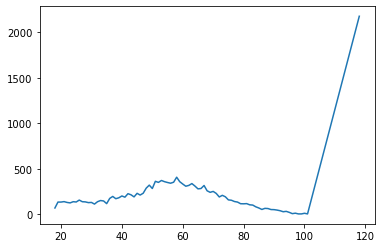

In [12]:
plt.plot(profile.age.value_counts().sort_index())
plt.show()

In [13]:
# exclude ages greater than 80
# notice that occurrances with age = 118 are highly correlated with null values in other columns

profile['age_new'] = profile.age.apply(lambda x: x if x <= 80 else None)
profile.head()

,gender,age,id,became_member_on,income,age_new
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,55.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,75.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,NaN


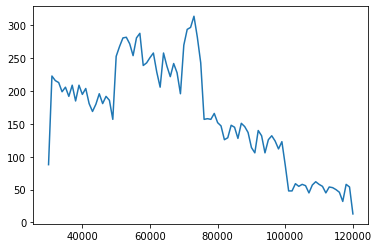

In [14]:
# distribution of income looks good
plt.plot(profile.income.value_counts().sort_index())
plt.show()

In [15]:
# check gender info
profile.gender.value_counts(dropna = False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

In [16]:
profile_cleaned = profile.dropna().copy()

In [17]:
# create bins for tenure based on membership date
# its a ordinal value field. [5,4,3,2] labels are kind of arbitrary, 
# but assuming monotonic relations, we should be able to get a directional result

tenure_bins = np.array([20130101, 20151231, 20161231, 20171231, 20181231])
tenure_label = [5,4,3,2]
profile_cleaned['tenure_bins'] = pd.cut(profile_cleaned.became_member_on, tenure_bins, labels = tenure_label)

In [18]:
# handle categorical values

profile_cleaned = pd.concat([profile_cleaned, pd.get_dummies(profile_cleaned.gender, prefix='gen')], axis = 1) \
            .drop(['age', 'became_member_on', 'gender', 'gen_M'], axis = 1)

In [19]:
profile_cleaned.head()

,id,income,age_new,tenure_bins,gen_F,gen_O
1,0610b486422d4921ae7d2bf64640c50b,112000.0,55.0,3,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75.0,3,1,0
5,e2127556f4f64592b11af22de27a7932,70000.0,68.0,2,0,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,65.0,2,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,58.0,3,0,0


## Transcript Dataset

In [20]:
# will need to extract data from value field
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
# iterate through the column and find all possible keys

all_keys = set()
for row in range(transcript.shape[0]):
    all_keys = all_keys.union(transcript.value.iloc[row].keys())
all_keys

{'amount', 'offer id', 'offer_id', 'reward'}

In [22]:
# create function to extract value by key

def get_dict_val(orig_val, key):
    try:
        res = orig_val[key]
    except:
        res = None
    return res

In [23]:
transcript_cleaned = transcript.copy()

In [24]:
transcript_cleaned['offer id'] = transcript_cleaned.value.apply(lambda x: get_dict_val(x, 'offer id'))
transcript_cleaned['offer_id'] = transcript_cleaned.value.apply(lambda x: get_dict_val(x, 'offer_id'))
transcript_cleaned['reward'] = transcript_cleaned.value.apply(lambda x: get_dict_val(x, 'reward'))
transcript_cleaned['amount'] = transcript_cleaned.value.apply(lambda x: get_dict_val(x, 'amount'))

In [25]:
# check if there are rows with both offer id and offer_id
# if not then we can combine the 2 columns

transcript_cleaned[(~transcript_cleaned['offer id'].isnull()) & (~transcript_cleaned['offer_id'].isnull())]

,person,event,value,time,offer id,offer_id,reward,amount


In [26]:
transcript_cleaned['offer_id'] = transcript_cleaned['offer id'].fillna('').astype('str') \
                         + transcript_cleaned['offer_id'].fillna('').astype('str')
transcript_cleaned.drop('offer id', axis = 1, inplace=True)
transcript_cleaned.drop('value', axis = 1, inplace=True)

In [27]:
transcript_cleaned.head()

,person,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


# Algorithms and Techniques

How should we send out these promotions is a general question. Our ultimate goal is for the promotions to generate more revenue. We can break it into different pieces: <br/>
- Who are most likely to see the promotions? What is the most effective channel to share the offers?
- Who would respond to the offers if they see it?
- Would they still make the same purchase without seeing the offer?


We will use logistic regression classifier to analyze the above problems respectively. 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [29]:
def logistic_model_train(dataset):
    X = dataset.iloc[:, 1:].values
    y = dataset.iloc[:, 0].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    print('============================')
    print('SKLEARN')
    print('============================')
    
    # feature scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # model fit
    classifier = LogisticRegression(random_state = 200, solver='sag')
    classifier.fit(X_train, y_train)
    
    # prediction
    y_pred = classifier.predict(X_test)
    
    # confusion matrix and accuracy
    recall_score, f1_score
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix: \n', cm)
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('Precision: %.2f' % precision_score(y_test, y_pred))
    print('Recall: %.2f' % recall_score(y_test, y_pred))
    print('F1_score: %.2f' % f1_score(y_test, y_pred))
    
    # https://pythonguides.com/scikit-learn-logistic-regression/
    importance = classifier.coef_[0]
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature %0d, %s , Score: %.5f' % (i+1,dataset.columns[i + 1],v))
    # plot feature importance
    plt.bar([x + 1 for x in range(len(importance))], importance)
    plt.show()
    
    print('============================')
    print('STATSMODELS SUMMARY')
    print('============================')
    model = sm.Logit(y_train, sm.add_constant(X_train))
    results = model.fit(method = 'newton')
    print(results.summary2())
    
    return classifier, model

## Predict whether they will view it

For users to be affected by the promotions, the first step is for them to view the offer once sent. we can compare what demographic groups have a higher possibility to view the offer.

### Data Cleaning

#### Preprocessing

In [30]:
transcript_received = transcript_cleaned[transcript_cleaned.event == 'offer received'].copy()
transcript_viewed = transcript_cleaned[transcript_cleaned.event == 'offer viewed'].copy()

In [31]:
# Double check that there are no viewed records with no received records
transcript_viewed[~transcript_viewed.person.isin(transcript_received.person.unique())]

,person,event,time,offer_id,reward,amount


Check if there are duplicates, i.e. same offer sent to same person multiple times, and have multiple views. We can't identify which one they saw, but since we only need to know whether they are viewed or not, we can just drop duplicates and not use time field

In [32]:
transcript_received[transcript_received.duplicated(subset = ['event','person', 'offer_id'], keep = False)] \
    .sort_values(['person', 'offer_id']).head(10)

,person,event,time,offer_id,reward,amount
56475,00116118485d4dfda04fdbaba9a87b5c,offer received,168,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
248359,00116118485d4dfda04fdbaba9a87b5c,offer received,576,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
1889,0020c2b971eb4e9188eac86d93036a77,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
112698,0020c2b971eb4e9188eac86d93036a77,offer received,336,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
55857,003d66b6608740288d6cc97a6903f4f0,offer received,168,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
158081,003d66b6608740288d6cc97a6903f4f0,offer received,408,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
159010,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,408,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
253486,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,576,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
163335,004c5799adbf42868b9cff0396190900,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
214247,004c5799adbf42868b9cff0396190900,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN


In [33]:
# drop duplicates
transcript_received.drop_duplicates(subset=['person', 'offer_id'], inplace = True)
transcript_viewed.drop_duplicates(subset=['person', 'offer_id'], inplace = True)

In [34]:
# combine the data with only important fields

df_tran_1 = pd.merge(transcript_received.drop(['event', 'reward', 'amount'], axis=1), 
         transcript_viewed.drop(['event', 'reward', 'amount'], axis = 1), 
         how = 'left',
         left_on = ['person', 'offer_id'], 
         right_on = ['person', 'offer_id'], 
         suffixes=('_recv', '_view'))

In [35]:
df_tran_1['is_viewed'] = np.where(df_tran_1.time_view.isnull(),0,1)
df_tran_1 = df_tran_1.drop(['time_recv', 'time_view'], axis = 1)
df_tran_1.head()

,person,offer_id,is_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,1


#### Combine Data

Assuming the possibility of an offer being viewed is irrelavant of what type of offer it is, or other offer related information, since these data are not visible before users view the offer. We'll drop related columns for current dataset.

In [36]:
dataset_1 = pd.merge(
            pd.merge(
                df_tran_1
                , portfolio_cleaned.drop(['difficulty', 'duration','reward', 'type_bogo', 'type_discount'], axis = 1)
                , left_on = 'offer_id'
                , right_on = 'id').drop(['offer_id', 'id'], axis = 1)
             , profile_cleaned
             , left_on = 'person'
             , right_on = 'id').drop(['person', 'id'], axis = 1)

In [37]:
dataset_1.head()

,is_viewed,ch_web,ch_mobile,ch_social,income,age_new,tenure_bins,gen_F,gen_O
0,1,1,1,0,100000.0,75.0,3,1,0
1,1,1,1,1,100000.0,75.0,3,1,0
2,1,0,1,1,100000.0,75.0,3,1,0
3,1,0,1,1,100000.0,75.0,3,1,0
4,1,1,1,0,41000.0,59.0,5,0,0


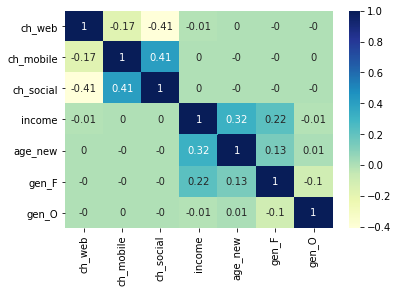

In [38]:
sns.heatmap(dataset_1.drop('is_viewed', axis = 1).corr().round(2), cmap = 'YlGnBu', annot = True)
plt.show()

### Logistic Regression

ref: below uses sample codes from https://www.udemy.com/course/machinelearning/

SKLEARN
Confusion Matrix: 
 [[1203 1819]
 [ 627 9242]]
Accuracy: 0.81
Precision: 0.84
Recall: 0.94
F1_score: 0.88
Feature 1, ch_web , Score: 0.46269
Feature 2, ch_mobile , Score: 0.23760
Feature 3, ch_social , Score: 1.56722
Feature 4, income , Score: 0.11875
Feature 5, age_new , Score: 0.07819
Feature 6, tenure_bins , Score: 0.04896
Feature 7, gen_F , Score: 0.02618
Feature 8, gen_O , Score: 0.09047


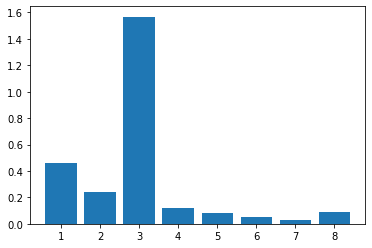

STATSMODELS SUMMARY
Optimization terminated successfully.
         Current function value: 0.389549
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.277     
Dependent Variable: y                AIC:              30147.2801
Date:               2022-02-23 22:40 BIC:              30224.3459
No. Observations:   38672            Log-Likelihood:   -15065.   
Df Model:           8                LL-Null:          -20841.   
Df Residuals:       38663            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-------------------------------------------------------------------
const       1.8276     0.0209   87.4788   0.0000    1.7867   1.8686
x1          0.4635     0.0239   19.381

In [39]:
sklearn_clf_1, stats_model_1 = logistic_model_train(dataset_1)

### Reduce Dimension

In [40]:
# because gen_F is not significant
dataset_1.drop(['gen_F'], axis = 1, inplace = True)

In [41]:
dataset_1.head()

,is_viewed,ch_web,ch_mobile,ch_social,income,age_new,tenure_bins,gen_O
0,1,1,1,0,100000.0,75.0,3,0
1,1,1,1,1,100000.0,75.0,3,0
2,1,0,1,1,100000.0,75.0,3,0
3,1,0,1,1,100000.0,75.0,3,0
4,1,1,1,0,41000.0,59.0,5,0


SKLEARN
Confusion Matrix: 
 [[1189 1833]
 [ 635 9234]]
Accuracy: 0.81
Precision: 0.83
Recall: 0.94
F1_score: 0.88
Feature 1, ch_web , Score: 0.46229
Feature 2, ch_mobile , Score: 0.23755
Feature 3, ch_social , Score: 1.56697
Feature 4, income , Score: 0.12389
Feature 5, age_new , Score: 0.07998
Feature 6, tenure_bins , Score: 0.04896
Feature 7, gen_O , Score: 0.08794


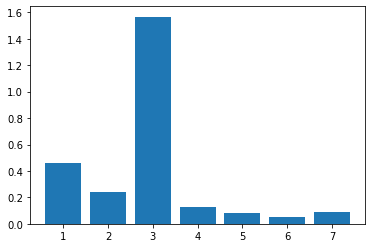

STATSMODELS SUMMARY
Optimization terminated successfully.
         Current function value: 0.389590
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.277     
Dependent Variable: y                AIC:              30148.4160
Date:               2022-02-23 22:40 BIC:              30216.9190
No. Observations:   38672            Log-Likelihood:   -15066.   
Df Model:           7                LL-Null:          -20841.   
Df Residuals:       38664            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
--------------------------------------------------------------------
         Coef.     Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const    1.8274      0.0209    87.4760    0.0000    1.7865    1.8684
x1       0.4632      0.0239    19.

In [42]:
sklearn_clf_1, stats_model_1 = logistic_model_train(dataset_1)

### Conclusion

All coeficients are positive. <br/>
- First 3 variables are indicators for promotion channels. Any of those will bring more offer views, and social is the most effective ways among all
- Other than promotion channels, income, age, tenure and self identified non-binary gender all have positive relationship with the posibility to view the offer. First 3 are also correlated with each other, as people tend to have higher income and longer tenure when they are older. But not so much as we need to be concerned about multicollinearity

## Predict if a user views an offer, how likely they will complete it

### Data Cleaning

#### Preprocessing

Offer Completed after Viewed

First need to exclude offer completed without viewing it, or before it's viewed

In [43]:
transcript_cleaned.head()

,person,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [44]:
df_first_viewed = transcript_cleaned[transcript_cleaned.event == 'offer viewed'].groupby(['person', 'offer_id'])['time'].min().reset_index()

In [45]:
df_first_viewed.head()

,person,offer_id,time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216


In [46]:
transcript_completed = transcript_cleaned[transcript_cleaned.event == 'offer completed'].copy()

In [47]:
transcript_completed.drop_duplicates(['person', 'offer_id', 'time'], inplace = True)

In [48]:
# Subset of offer completed from views

df_comp_view = pd.merge(transcript_completed, df_first_viewed, 
                        how = 'left',
                        left_on=['person', 'offer_id'], right_on=['person', 'offer_id'])
df_comp_view = df_comp_view.loc[~((df_comp_view.time_y.isnull()) | (df_comp_view.time_x < df_comp_view.time_y))]

In [49]:
df_comp_view.drop_duplicates(['person', 'offer_id'], inplace = True)
df_comp_view = df_comp_view[['person', 'offer_id']]
df_comp_view['is_completed'] = 1
df_comp_view.head()

,person,offer_id,is_completed
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,1
2,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,1
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,1
5,227f2d69e46a4899b70d48182822cff6,4d5c57ea9a6940dd891ad53e9dbe8da0,1


All offers viewed with indicator whether they are completed or not

In [50]:
df_tran_2 = pd.merge(df_first_viewed, df_comp_view, 
         how = 'left',
         left_on=['person', 'offer_id'], right_on = ['person', 'offer_id'])
df_tran_2['is_completed'] = df_tran_2.is_completed.fillna(0)
df_tran_2.drop('time', axis = 1, inplace = True)
df_tran_2['is_completed'] = df_tran_2.is_completed.astype('int')
df_tran_2.head()

,person,offer_id,is_completed
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0


In [51]:
df_tran_2.is_completed.value_counts()

0    27763
1    21372
Name: is_completed, dtype: int64

#### Combine Data

In [52]:
dataset_2 = pd.merge(
        pd.merge(
            df_tran_2
            , portfolio_cleaned
            , left_on = 'offer_id'
            , right_on = 'id').drop(['offer_id', 'id'], axis = 1)
         , profile_cleaned
         , left_on = 'person'
         , right_on = 'id').drop(['person', 'id'], axis = 1)

In [53]:
dataset_2.head()

,is_completed,reward,difficulty,duration,ch_web,ch_mobile,ch_social,type_bogo,type_discount,income,age_new,tenure_bins,gen_F,gen_O
0,0,0,0,4,1,1,0,0,0,72000.0,33.0,3,0,0
1,0,0,0,3,0,1,1,0,0,72000.0,33.0,3,0,0
2,0,5,5,5,1,1,1,1,0,72000.0,33.0,3,0,0
3,0,2,10,10,1,1,1,0,1,72000.0,33.0,3,0,0
4,0,0,0,4,1,1,0,0,0,57000.0,40.0,2,0,1


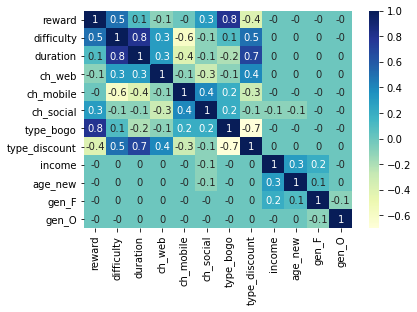

In [54]:
sns.heatmap(dataset_2.drop('is_completed', axis = 1).corr().round(1), cmap = 'YlGnBu', annot = True)
plt.show()

### Logistic Regression

SKLEARN
Confusion Matrix: 
 [[3345 1752]
 [1011 3807]]
Accuracy: 0.72
Precision: 0.68
Recall: 0.79
F1_score: 0.73
Feature 1, reward , Score: -0.00172
Feature 2, difficulty , Score: -0.42799
Feature 3, duration , Score: 0.31378
Feature 4, ch_web , Score: 0.11442
Feature 5, ch_mobile , Score: -0.11048
Feature 6, ch_social , Score: 0.05263
Feature 7, type_bogo , Score: 3.90278
Feature 8, type_discount , Score: 3.99488
Feature 9, income , Score: 0.27979
Feature 10, age_new , Score: 0.04379
Feature 11, tenure_bins , Score: 0.52436
Feature 12, gen_F , Score: 0.20120
Feature 13, gen_O , Score: 0.07691


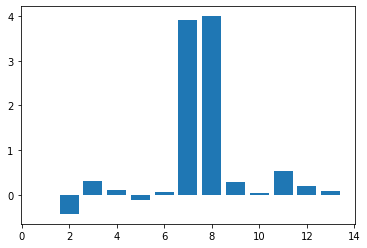

STATSMODELS SUMMARY
         Current function value: 0.496776
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.282     
Dependent Variable: y                AIC:              29579.2067
Date:               2022-02-23 22:40 BIC:              29695.4116
No. Observations:   29743            Log-Likelihood:   -14776.   
Df Model:           13               LL-Null:          -20586.   
Df Residuals:       29729            LLR p-value:      0.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.     z     P>|z|     [0.025      0.975] 
------------------------------------------------------------------
const   -4.3254   468.7004  -0.0092  0.9926   -922.9612   914.3105
x1      -0.0074     0.0649  -0.1136  0.9096     -0.1347     0.1199
x2      -0.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [55]:
sklearn_clf_2, stats_model_2 = logistic_model_train(dataset_2)

### Reduce Dimension

In [56]:
# because not significant
dataset_2.drop(['reward', 'ch_web', 'ch_social', 'age_new'], axis = 1, inplace = True)
# multicolinearity
dataset_2.drop(['type_bogo'], axis = 1, inplace = True)

In [57]:
dataset_2.head()

,is_completed,difficulty,duration,ch_mobile,type_discount,income,tenure_bins,gen_F,gen_O
0,0,0,4,1,0,72000.0,3,0,0
1,0,0,3,1,0,72000.0,3,0,0
2,0,5,5,1,0,72000.0,3,0,0
3,0,10,10,1,1,72000.0,3,0,0
4,0,0,4,1,0,57000.0,2,0,1


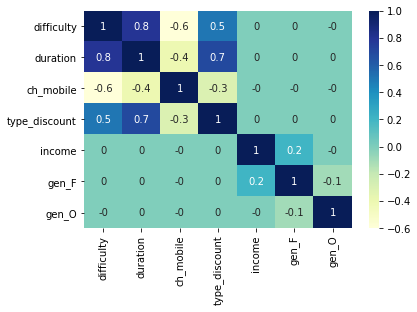

In [58]:
sns.heatmap(dataset_2.drop('is_completed', axis = 1).corr().round(1), cmap = 'YlGnBu', annot = True)
plt.show()

SKLEARN
Confusion Matrix: 
 [[3498 1599]
 [1512 3306]]
Accuracy: 0.69
Precision: 0.67
Recall: 0.69
F1_score: 0.68
Feature 1, difficulty , Score: 0.68153
Feature 2, duration , Score: 0.59132
Feature 3, ch_mobile , Score: 0.52823
Feature 4, type_discount , Score: 0.10644
Feature 5, income , Score: 0.26830
Feature 6, tenure_bins , Score: 0.47282
Feature 7, gen_F , Score: 0.18805
Feature 8, gen_O , Score: 0.06843


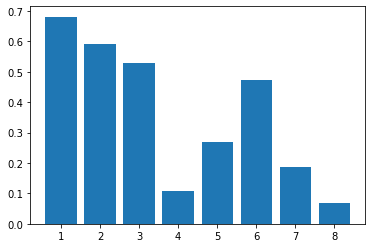

STATSMODELS SUMMARY
Optimization terminated successfully.
         Current function value: 0.561465
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.189     
Dependent Variable: y                AIC:              33417.3332
Date:               2022-02-23 22:40 BIC:              33492.0363
No. Observations:   29743            Log-Likelihood:   -16700.   
Df Model:           8                LL-Null:          -20586.   
Df Residuals:       29734            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -0.1481     0.0135   -10.9687   0.0000   -0.1746   -0.1216
x1        0.6819     0.0247    27.6302

In [59]:
sklearn_clf_2, stats_model_2 = logistic_model_train(dataset_2)

## Purchase made without offer views

From above analysis, we learned some properties would improve the likelihood of offers being viewed. However since we only have data for users participated in the promotion experiment, without a control group observed, we couldn't make the conclusion that the behaviors were affected by the offers. For example, some users would make the purchases no matter whether they saw the offer or not. <br/>
By analyzing user behaviors without 'offer viewed' record, we can have a qualitative understanding about what type of users might make more purchases than others.

In [60]:
df_not_viewed = df_tran_1[df_tran_1.is_viewed == 0]
df_not_viewed.head()

,person,offer_id,is_viewed
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0
17,65aba5c617294649aeb624da249e1ee5,2906b810c7d4411798c6938adc9daaa5,0
20,868317b9be554cb18e50bc68484749a2,2906b810c7d4411798c6938adc9daaa5,0
23,4beeb3ed64dd4898b0edf2f6b67426d3,2906b810c7d4411798c6938adc9daaa5,0
25,25c906289d154b66bf579693f89481c9,2906b810c7d4411798c6938adc9daaa5,0


In [61]:
df_no_view_completed = transcript_completed[['person', 'offer_id']].drop_duplicates()

In [62]:
df_no_view_completed['is_completed'] = 1

In [63]:
df_no_view_completed

,person,offer_id,is_completed
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,1
12672,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,1
12679,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
12692,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,1
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,1
...,...,...,...
306470,452cdae2c68e4732a4177d3929562690,fafdcd668e3743c1bb461111dcafc2a4,1
306475,0c027f5f34dd4b9eba0a25785c611273,2298d6c36e964ae4a3e7e9706d1fb8c2,1
306497,a6f84f4e976f44508c358cc9aba6d2b3,2298d6c36e964ae4a3e7e9706d1fb8c2,1
306509,8431c16f8e1d440880db371a68f82dd0,fafdcd668e3743c1bb461111dcafc2a4,1


In [64]:
df_not_viewed_check = pd.merge(df_not_viewed, df_no_view_completed, how = 'left')

In [65]:
df_not_viewed_check['is_completed'] = df_not_viewed_check['is_completed'].fillna(0)
df_not_viewed_check.drop('is_viewed', axis = 1, inplace = True)

### Data Cleaning

In [66]:
dataset = pd.merge(df_not_viewed_check
         , profile_cleaned
         , left_on = 'person'
         , right_on = 'id').drop(['person', 'id'], axis = 1)

In [67]:
dataset.drop('offer_id', axis = 1, inplace=True)

In [68]:
dataset.head()

,is_completed,income,age_new,tenure_bins,gen_F,gen_O
0,0.0,51000.0,58.0,3,0,0
1,0.0,80000.0,54.0,3,1,0
2,0.0,64000.0,76.0,5,0,0
3,0.0,107000.0,74.0,5,1,0
4,1.0,98000.0,61.0,3,0,0


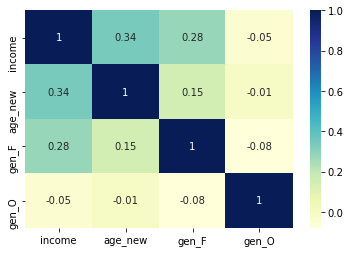

In [69]:
sns.heatmap(dataset.drop('is_completed', axis = 1).corr().round(2), cmap = 'YlGnBu', annot = True)
plt.show()

### Logistic Regression

SKLEARN
Confusion Matrix: 
 [[1741  214]
 [ 782  240]]
Accuracy: 0.67
Precision: 0.53
Recall: 0.23
F1_score: 0.33
Feature 1, income , Score: 0.37450
Feature 2, age_new , Score: 0.05392
Feature 3, tenure_bins , Score: 0.33887
Feature 4, gen_F , Score: 0.22106
Feature 5, gen_O , Score: 0.03528


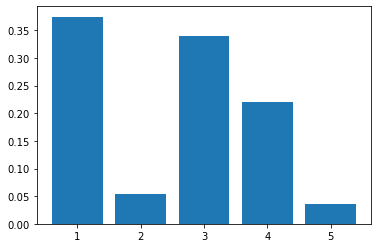

STATSMODELS SUMMARY
Optimization terminated successfully.
         Current function value: 0.602832
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.065      
Dependent Variable: y                AIC:              10776.1750 
Date:               2022-02-23 22:40 BIC:              10818.7567 
No. Observations:   8928             Log-Likelihood:   -5382.1    
Df Model:           5                LL-Null:          -5756.0    
Df Residuals:       8922             LLR p-value:      2.2042e-159
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -0.6931     0.0236   -29.4109   0.0000   -0.7393   -0.6469
x1         0.3747     0.0

In [70]:
sklearn_clf, stats_model= logistic_model_train(dataset)

### Conclusion

From above, we know that users with xxxxxxx are more likely to make purchases irrelavant with the offer. Though we cannot compare the coefficient values directly or make qualitative conclusions since they are 2 groups with fundamental differences - one is more active on the promotion channels based on whether they saw the offer or not. In order to xxxxx, we'll need to use methodologies like A/B testing 